# Quantum Image Classification on Alzheimer MRI (Binary)  
## FRQI Encoding + Fidelity-Based Nearest-Centroid Classifier  

> **Input:** `processed/train_0.npy`, `train_1.npy`, `test_0.npy`, `test_1.npy` (θ-scaled 16×16 images)  
> **Quantum encoding:** Flexible Representation of Quantum Images (FRQI) → `n+1` qubits (`n = 8` → 256 pixels)  
> **Classifier:** Compute fidelity between a test image and the *average* state of each class → pick the class with the highest fidelity  
> **Metric:** State-vector fidelity (exact) **and** shot-noise fidelity (simulated measurements)

# 0. Install Qiskit & mount Drive

In [40]:
!pip install qiskit qiskit-aer
!pip install matplotlib

In [41]:
import qiskit as qk
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.states.statevector import Statevector
from qiskit.quantum_info import DensityMatrix
from math import pi
import numpy as np
from qiskit.circuit.library.standard_gates import RYGate
import matplotlib.pyplot as plt

In [42]:
# --- Mount Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Root folder (UPDATE IF NEEDED) ---
ROOT = "/content/drive/MyDrive/Colab Notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All heavy libraries are installed once per session.
The four .npy files produced by Theta_Values.ipynb are expected in ROOT + "processed/"
> Statevector → exact simulation (no shot noise).

> Aer → fast CPU simulator for shot-noise experiments.

# 1. Flexible Representation of Quantum Images (FRQI)
Build a quantum circuit that encodes a 256-pixel image into a 9-qubit FRQI state:
- 8 qubits: binary pixel address  
- 1 ancillary qubit: color intensity via controlled-RY rotations  
- Uses incremental X-gates to transition between consecutive pixel indices

In [43]:
def get_U(n, thetas):
    qr = QuantumRegister(n+1)
    qc = QuantumCircuit(qr)

    binary = []

    n_pixels = 2**n

    for i in range(n_pixels):
            binary.append(f'{i:0{int(np.log2(n_pixels))}b}')

    RY_gate = RYGate(theta=2*thetas[0]).control(n)

    for i in range(n):
        qc.h(i)

    qc.barrier()

    qc.append(RY_gate, qr)

    qc.barrier()

    for j in range(n_pixels-1):
        ls_prev = binary[j]
        ls_next = binary[j+1]

        for i in range(n):
            if int(ls_prev[i]) == 0 and int(ls_next[i]) == 1:
                qc.x(i)

            if int(ls_prev[i]) == 1 and int(ls_next[i]) == 0:
                qc.x(i)

        RY_gate = RYGate(theta=2*thetas[j+1]).control(n)

        qc.append(RY_gate, qr)

        qc.barrier()

    return qc

# 2. Compute fidelity: statevector vs shotnoise

### 2.1 Fidelity Metrics (Exact Simulation)
Compute:
- **Inner product** ⟨ψ_ref | ψ_trial⟩ → complex overlap  
- **L2 distance** between state vectors (for debugging)  
Used to compare test image state with class centroids **without measurement noise**.

In [44]:
def statevector_fidelity(U_ref, U_trial, n):
    state_ref = np.array(Statevector(U_ref))
    state_trial = np.array(Statevector(U_trial))

    return state_ref.conj().T @ state_trial

def statevector_L2(U_ref, U_trial, n, n_shots):
    state_ref = np.array(Statevector(U_ref))
    state_trial = np.array(Statevector(U_trial))

    return np.sum(np.absolute(state_ref - state_trial)**2)


### 2.2 Fidelity with Shot Noise (SWAP Test Simulation)
Estimate |⟨ψ_ref | ψ_trial⟩|² using the **SWAP test**:
1. Compose reference circuit with inverse of trial  
2. Measure all qubits  
3. Probability of all-zero outcome → fidelity  
Simulates real quantum hardware behavior.

In [45]:
def shotnoise_fidelity(U_ref, U_trial, n, n_shots):
    qc = U_ref.compose(U_trial.inverse())
    qc.measure_all()

    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    result = aer_sim.run(t_qc, shots=n_shots).result()
    counts = result.get_counts(qc)


    if str('0'*(n+1)) in counts and str('1'+'0'*(n)) in counts:
        return (counts['0'*(n+1)] + counts['1' + '0'*(n)])/n_shots
    if str('0'*(n+1)) in counts and str('1'+'0'*(n)) not in counts:
        return (counts['0'*(n+1)])/n_shots
    if str('0'*(n+1)) not in counts and str('1'+'0'*(n)) in counts:
        return (counts['1'+'0'*(n)])/n_shots

# 3. Load the image dataset

In [46]:
import numpy as np
import os

# ---- paths ----
DATA_DIR = f'{ROOT}/processed'

# ---- binary classes -------------------------------------------------
# 0 = NonDemented   (reference class)
# 1 = Demented      (all other three classes combined)

train_0 = np.load(os.path.join(DATA_DIR, "train_0.npy"))   # NonDemented train
train_1 = np.load(os.path.join(DATA_DIR, "train_1.npy"))   # Demented train
test_0  = np.load(os.path.join(DATA_DIR, "test_0.npy"))    # NonDemented test
test_1  = np.load(os.path.join(DATA_DIR, "test_1.npy"))    # Demented test

print(f"train NonDem: {train_0.shape}   Demented: {train_1.shape}")
print(f"test  NonDem: {test_0.shape}   Demented: {test_1.shape}")

# -------------------------------------------------
# Build the three lists required by the FRQI code
# -------------------------------------------------
n_images = 30                                 # how many pairs you want to test
np.random.seed(42)

# 1. reference images  → random NonDemented from the *training* set
ref_idx   = np.random.choice(len(train_0), size=n_images, replace=False)
img_refs  = [train_0[i].reshape(16,16) for i in ref_idx]

# 2. “similar” trial images → random NonDemented from the *test* set
sim_idx   = np.random.choice(len(test_0), size=n_images, replace=False)
img_trial_similars = [test_0[i].reshape(16,16) for i in sim_idx]

# 3. “different” trial images → random Demented from the *test* set
diff_idx  = np.random.choice(len(test_1), size=n_images, replace=False)
img_trial_differents = [test_1[i].reshape(16,16) for i in diff_idx]

print(f"Prepared {n_images} reference / similar / different images")

train NonDem: (2560, 256)   Demented: (2560, 256)
test  NonDem: (640, 256)   Demented: (640, 256)
Prepared 30 reference / similar / different images


Text(0.5, 1.0, 'Different')

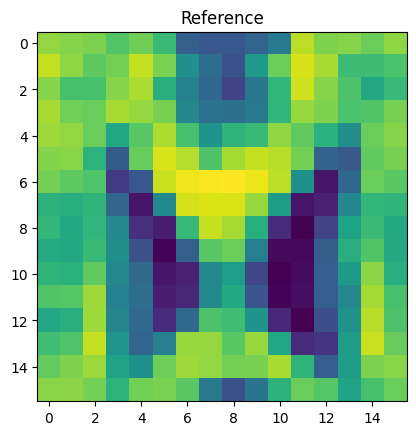

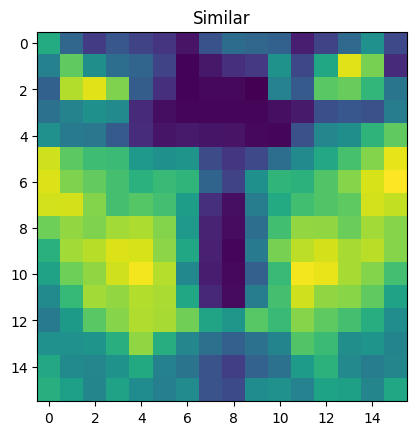

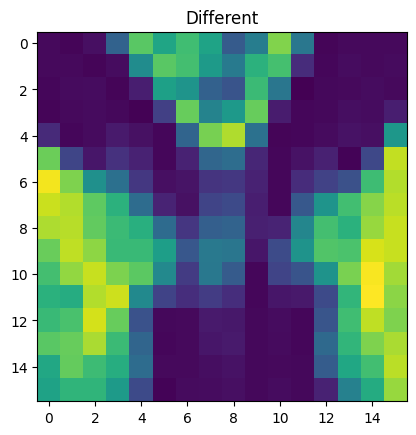

In [47]:
fig, ax = plt.subplots()
ax.imshow(img_refs[0])
ax.set_title("Reference")

fig, ax = plt.subplots()
ax.imshow(img_trial_similars[0])
ax.set_title("Similar")

fig, ax = plt.subplots()
ax.imshow(img_trial_differents[0])
ax.set_title("Different")


# 4. Patch trick

In [48]:
def get_patches(img, patch_side):
    img_patches = []
    patch_size = patch_side**2
    n_patches = img.shape[0]//patch_side
    for i in range(n_patches):
        for j in range(n_patches):
            img_patches.append(img[i*patch_side:(i+1)*patch_side, j*patch_side:(j+1)*patch_side])

    return np.array(img_patches)

# 5. Exact Fidelity on Image Patches (Statevector)
Compute **perfect (noise-free)** fidelity between corresponding patches of two images:
- Each patch (e.g., 2×2 = 4 pixels) is encoded via FRQI into a small quantum state.
- Uses `Statevector` → **exact simulation** (no sampling, no shot noise).
- Fidelity = |⟨ψ_ref | ψ_trial⟩|
- "Closeness" metric: `2 * (1 - √|fid|)` → lower = more similar
- **Fast & deterministic** — ideal for debugging and setting thresholds.

In [49]:
def statevector_fidelity_patches(imgref_patches, imgtrial_patches):
    cfids = []
    tds = []

    for i in range(imgref_patches.shape[0]):
        imgref = imgref_patches[i]
        imgtrial = imgtrial_patches[i]

        theta_ref = imgref.flatten()
        theta_trial = imgtrial.flatten()

        n = int(np.log2(theta_ref.size))

        U_ref = get_U(n, theta_ref)
        U_trial = get_U(n, theta_trial)

        cfid = statevector_fidelity(U_ref, U_trial, n)
        cfids.append(cfid)
        tds.append(2*(1-np.sqrt(cfid)))

    cfids = np.array(cfids)
    tds = np.array(tds)

    return cfids, tds

td_mean_similars = []
td_mean_differents = []

for i in range(n_images):
    imgref_patches = get_patches(img_refs[0], 2)
    imgtrialsimilar_patches = get_patches(img_trial_similars[i], 2)
    imgtrialdifferent_patches = get_patches(img_trial_differents[i], 2)

    cfids_similar, tds_similar = statevector_fidelity_patches(imgref_patches, imgtrialsimilar_patches)
    cfids_different, tds_different = statevector_fidelity_patches(imgref_patches, imgtrialdifferent_patches)

    td_mean_similars.append(np.mean(tds_similar, axis = 0))
    td_mean_differents.append(np.mean(tds_different, axis = 0))

# 6. Plotting

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Figure')

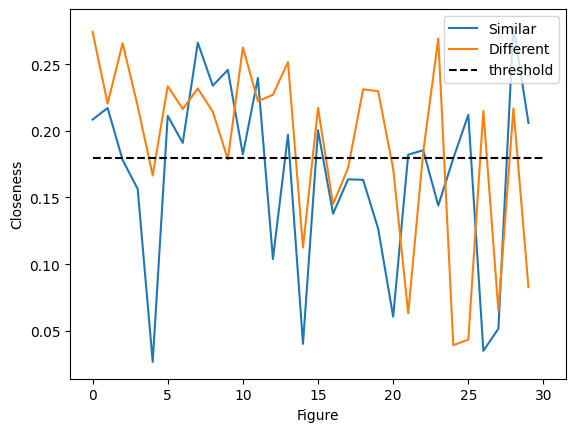

In [50]:
plt.plot(td_mean_similars, label = 'Similar')
plt.plot(td_mean_differents, label = 'Different')
plt.hlines(0.18, 0, n_images, label='threshold', linestyle='dashed', color='black')

plt.legend()
plt.ylabel("Closeness")
plt.xlabel("Figure")


# 7. Fidelity with Shot Noise on Patches (SWAP Test)
Compute approximate fidelity per image patch using simulated measurements:
- Similar to exact `statevector_fidelity_patches`, but calls `shotnoise_fidelity` instead.
- High `n_shots` reduces variance but increases runtime.
- Returns per-patch fidelities and derived 'closeness' metric (2*(1 - sqrt(fid))).
- Used to simulate noisy quantum hardware for realistic classification.

In [ ]:
def shotnoise_fidelity_patches(imgref_patches, imgtrial_patches, n_shots):
    cfids = []
    tds = []

    for i in range(imgref_patches.shape[0]):
        imgref = imgref_patches[i]
        imgtrial = imgtrial_patches[i]

        theta_ref = imgref.flatten()
        theta_trial = imgtrial.flatten()

        n = int(np.log2(theta_ref.size))

        U_ref = get_U(n, theta_ref)
        U_trial = get_U(n, theta_trial)

        cfid = shotnoise_fidelity(U_ref, U_trial, n, n_shots)

        cfids.append(cfid)
        tds.append(2*(1-np.sqrt(cfid)))

    cfids = np.array(cfids)
    tds = np.array(tds)

    return cfids, tds

td_mean_similars = []
td_mean_differents = []
n_shots = 100000

for i in range(n_images):
    imgref_patches = get_patches(img_refs[0], 2)
    imgtrialsimilar_patches = get_patches(img_trial_similars[i], 2)
    imgtrialdifferent_patches = get_patches(img_trial_differents[i], 2)

    cfids_similar, tds_similar = shotnoise_fidelity_patches(imgref_patches, imgtrialsimilar_patches, n_shots)
    cfids_different, tds_different = shotnoise_fidelity_patches(imgref_patches, imgtrialdifferent_patches, n_shots)

    td_mean_similars.append(np.mean(tds_similar, axis = 0))
    td_mean_differents.append(np.mean(tds_different, axis = 0))


In [ ]:
plt.plot(td_mean_similars[:15], label = 'Similar')
plt.plot(td_mean_differents[:15], label = 'Different')
plt.hlines(0.060, 0, 15, label='threshold', linestyle='dashed', color='black')

plt.legend()
plt.ylabel("Closeness")
plt.xlabel("Figure")

# 8. Build FRQI Circuit Factory for Full Images
Create a ready-to-use **FRQI quantum circuit** from a flattened θ-vector:
- `n_qubits = 4` → 2⁴ = 16 pixels → **4×4 image** (Note: 16×16 images need `n_qubits = 8`)
- `theta_vec`: 1D array of length 16 (or 256), values in [0, π/2]
- Calls `get_U(n, theta_vec)` → returns a **9-qubit circuit** (8 address + 1 color)
- Used to pre-build circuits for:
  - Reference images (`ref_circuits`)
  - Similar test images (`similar_circuits`)
  - Different test images (`different_circuits`)
- **Warning**: Current `n_qubits=4` only supports 4×4 patches. For full 16×16 images, set `n_qubits = 8`.

In [ ]:
n_qubits = 4                     # 2^4 = 16 → 16×16 image
def make_frqi_circuit(theta_vec):
    """theta_vec must be a flat array of length 256 (already in [0,π/2])"""
    return get_U(n_qubits, theta_vec)

ref_circuits      = [make_frqi_circuit(img.flatten()) for img in img_refs]
similar_circuits  = [make_frqi_circuit(img.flatten()) for img in img_trial_similars]
different_circuits= [make_frqi_circuit(img.flatten()) for img in img_trial_differents]

print(f"Created {len(ref_circuits)} reference, {len(similar_circuits)} similar, {len(different_circuits)} different FRQI circuits")

#9. Compute L2 distance (state-vector) for every pair

In [ ]:
n_shots = 8192                     # you can lower for speed
td_similar   = []
td_different = []

for i in range(n_images):
    ref = ref_circuits[i]
    sim = similar_circuits[i]
    dif = different_circuits[i]

    # L2 distance (state-vector, no shots)
    l2_sim = statevector_L2(ref, sim, n_qubits, n_shots)
    l2_dif = statevector_L2(ref, dif, n_qubits, n_shots)

    td_similar.append(l2_sim)
    td_different.append(l2_dif)

    if (i+1) % 10 == 0:
        print(f"processed {i+1}/{n_images}")

# Convert to numpy for easy plotting
td_mean_similars   = np.array(td_similar)
td_mean_differents = np.array(td_different)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(td_mean_similars,   marker='o', label='Similar (NonDem vs NonDem)')
plt.plot(td_mean_differents, marker='x', label='Different (NonDem vs Dem)')
plt.axhline(0.18, color='black', linestyle='--', label='threshold 0.18')

plt.title("L2 distance between reference and trial FRQI states")
plt.xlabel("Image index")
plt.ylabel("L2 distance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 10. Mean image trick

In [ ]:
def quantum_fidelity_patches(imgref_patches, imgtrial_patches, n_shots):
    cfids = []
    tds = []

    for i in range(imgref_patches.shape[0]):
        imgref = imgref_patches[i]
        imgtrial = imgtrial_patches[i]

        theta_ref = imgref.flatten()
        theta_trial = imgtrial.flatten()

        n = int(np.log2(theta_ref.size))

        U_ref = get_U(n, theta_ref)
        U_trial = get_U(n, theta_trial)

        cfid = shotnoise_fidelity(U_ref, U_trial, n, n_shots)

        cfids.append(cfid)
        tds.append(2*(1-np.sqrt(cfid)))

    cfids = np.array(cfids)
    tds = np.array(tds)

    return cfids, tds

td_meanimage_similars = []
td_meanimage_differents = []
n_shots = 100000

img_ref = np.mean(img_refs, axis = 0)
img_trial_similar_mean = np.mean(img_trial_similars, axis = 0)
img_trial_different_mean = np.mean(img_trial_differents, axis = 0)

imgref_patches = get_patches(img_ref, 2)
imgtrialsimilar_patches = get_patches(img_trial_similar_mean, 2)
imgtrialdifferent_patches = get_patches(img_trial_different_mean, 2)

cfids_similar, tds_similar = quantum_fidelity_patches(imgref_patches, imgtrialsimilar_patches, n_shots)
cfids_different, tds_different = quantum_fidelity_patches(imgref_patches, imgtrialdifferent_patches, n_shots)

td_meanimage_similars = np.mean(tds_similar, axis = 0)
td_meanimage_differents = np.mean(tds_different, axis = 0)

#11. Visualize Fidelity Trends
Plot average fidelity between:
- Similar images (same class)  
- Different images (different class)  
Dashed line = classification threshold (e.g., 0.18)

In [ ]:
plt.plot(td_mean_similars, label = 'Similar')
plt.plot(td_mean_differents, label = 'Different')
plt.hlines(0.18, 0, n_images, label='threshold', linestyle='dashed', color='black')

plt.legend()
plt.ylabel("Closeness")
plt.xlabel("Figure")